# Online Recommendation System

**IMPORTANT**: This code is written with Python 3 and appropiate installation is required.  Below are the packages called on throughout the program. 

On Amazon, you are looking to purchase a new washing machine and while shopping, you see a recommendation for a dryer.  Why?  These appear from analyzing previous purchase and search data for the company creating a recommendation for relevant products.  

The Online Retail Data Sales data set from the UCI Machine Learning Repository contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.  This retail is having an issue moving products and wants to implement a recommendation system on it’s website allowing for ease of purchase for their customers.  

I will build a model that will give recommendations from previous transactions of the retail.  The company will be able to implement this model on their website that will allow for recommendations of relevant products to their shoppers. As a result, products will move on the website increasing the income of the retail. 


In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
import re
from sklearn.model_selection import train_test_split
import numbers
import glob
import dask_ml.cluster

In [2]:
#Importing data and setting the index to datetime
os.chdir("C:\\Users\\dixon\\Desktop\\Data Science")
df=pd.read_csv('Online Retail.csv', parse_dates=True, index_col="InvoiceDate")
df= df.loc[lambda df_dropped: (df['UnitPrice'] > 0) & (df['Quantity'] > 0)]
df.StockCode = df.StockCode.str.extract('(\d+)', expand=False)
df=df.dropna(how='any')
df.StockCode = df['StockCode'].astype(int)
df.CustomerID = df['CustomerID'].astype(int)
data = df.drop(['InvoiceNo', 'Description','Country'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396470 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
InvoiceNo      396470 non-null object
StockCode      396470 non-null int32
Description    396470 non-null object
Quantity       396470 non-null int64
UnitPrice      396470 non-null float64
CustomerID     396470 non-null int32
Country        396470 non-null object
dtypes: float64(1), int32(2), int64(1), object(3)
memory usage: 21.2+ MB


In [3]:
data

,StockCode,Quantity,UnitPrice,CustomerID
InvoiceDate,,,,
2010-12-01 08:26:00,85123,6,2.55,17850
2010-12-01 08:26:00,71053,6,3.39,17850
2010-12-01 08:26:00,84406,8,2.75,17850
2010-12-01 08:26:00,84029,6,3.39,17850
2010-12-01 08:26:00,84029,6,3.39,17850
...,...,...,...,...
2011-12-09 12:50:00,22613,12,0.85,12680
2011-12-09 12:50:00,22899,6,2.10,12680
2011-12-09 12:50:00,23254,4,4.15,12680


Observe the data to see if there is any missing values and also obtain the data types. 

# 00. Data Wrangling

We first want to observe the raw data to see if there are things that stick out, also looking for patterns. 

In [5]:
data.describe()

,StockCode,Quantity,UnitPrice,CustomerID
count,396470.000000,396470.000000,396470.000000,396470.000000
mean,30753.164552,13.008520,2.884078,15301.447920
std,20610.907412,179.611245,4.354473,1709.773015
min,2.000000,1.000000,0.040000,12346.000000
25%,22027.000000,2.000000,1.250000,13975.000000
50%,22666.000000,6.000000,1.950000,15159.000000
75%,23270.000000,12.000000,3.750000,16801.000000
max,90214.000000,80995.000000,649.500000,18287.000000


In [6]:
non_uk = df.set_index('Country').drop(['United Kingdom'], axis = 0).reset_index()
uk = df['Country']

# 1. Visuals EDA

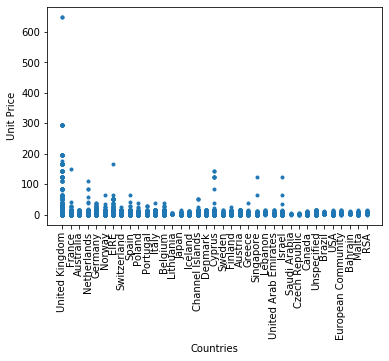

In [7]:
_ = plt.plot(df['Country'],df['UnitPrice'],marker='.',linestyle='none')
_ = plt.xlabel('Countries')
plt.xticks(rotation=90)
_ = plt.ylabel('Unit Price')
plt.show()

In [8]:
country_purchase = df.groupby('Country').InvoiceNo.value_counts()
country_unitprice = df.groupby('Country').UnitPrice.value_counts()

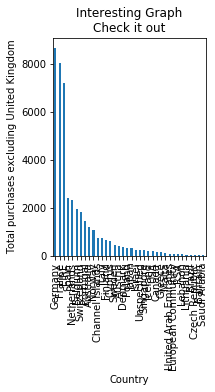

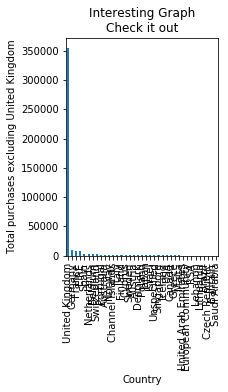

In [9]:
### make 2 bar graphs (one with UK and one without side by side)
plt.subplot(1,2,1); non_uk.Country.value_counts().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total purchases excluding United Kingdom')
plt.title('Interesting Graph\nCheck it out')
plt.show()
plt.subplot(1,2,2); df.Country.value_counts().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total purchases excluding United Kingdom')
plt.title('Interesting Graph\nCheck it out')
plt.show()
### violin plots in seabourn and next to each other
### outlier detection ////remove them for the visual data set


In [10]:
### violin plots in seabourn and next to each other
### outlier detection ////remove them for the visual data set
z = np.abs(stats.zscore(non_uk['Quantity']))
print(z)
threshold = 1
print(np.where(z > 1))
#sns.violinplot(x=non_uk['Country'],y=non_uk['Quantity'])

[0.05389868 0.05389868 0.1935508  ... 0.35851712 0.35851712 0.37913791]
(array([   33,    49,    98, ..., 42305, 42326, 42334], dtype=int64),)


In [11]:
### Test avg mean of unit prce/ctry and avg item sold/contry
### group by country and look at the avgs above
UnitPrice_mean = df.groupby('Country').UnitPrice.mean()
UnitPrice_std = df.groupby('Country').UnitPrice.std()

In [12]:
total_item = len(df.groupby('StockCode'))
df.groupby('Country').Quantity.mean()
### country on the y axis and quantity for the x-axis

Country
Australia               71.041490
Austria                 12.614583
Bahrain                 15.294118
Belgium                 11.866667
Brazil                  11.125000
Canada                  18.413333
Channel Islands         12.704150
Cyprus                  10.390523
Czech Republic          27.916667
Denmark                 22.324251
EIRE                    19.390793
European Community       8.596491
Finland                 16.395672
France                  13.768044
Germany                 13.645068
Greece                  10.915493
Iceland                 13.505495
Israel                  16.314516
Italy                   10.886640
Japan                   81.046729
Lebanon                  8.577778
Lithuania               18.628571
Malta                    8.788991
Netherlands             86.243755
Norway                  18.393130
Poland                  11.307692
Portugal                11.240000
RSA                      6.157895
Saudi Arabia             8.888889
Singap

# 2. inferrential stat linear regression (look for p-value and r2)

In [13]:
df1 = df_pos_price[['UnitPrice','Quantity']]
plt.plot(df1['UnitPrice'])
plt.show()
plt.plot(df1['Quantity'])
plt.show()
df1.shape

NameError: name 'df_pos_price' is not defined

In [ ]:
df_price = df1[(np.abs(df1['UnitPrice']-df1['UnitPrice'].mean())>(3*df1['UnitPrice'].std()))]
df_price = df1[(np.abs(df1['UnitPrice']-df1['UnitPrice'].mean())<=(3*df1['UnitPrice'].std()))]
df_price = df1[(np.abs(df1['Quantity']-df1['Quantity'].mean())<=(3*df1['Quantity'].std()))]
df_price = df1[(np.abs(df1['Quantity']-df1['Quantity'].mean())>(3*df1['Quantity'].std()))]
sns.violinplot(df_price['UnitPrice'])

In [ ]:
sns.violinplot(df_price['Quantity'])

In [ ]:
df_price['intercept']=1
lm=sm.OLS(df_price['UnitPrice'],df_price[['intercept','Quantity']])
slr_results = lm.fit()
slr_results.summary()

In [ ]:
np.random.seed(47)
N_rep = 10000
rep = np.empty(N_rep)

for i in range(N_rep):
        rep[i] = np.mean(np.random.choice(df_pos_price['UnitPrice'], size=len(df_pos_price['UnitPrice'])))

conf_int = np.percentile(rep,[2.5,97.5])
print(conf_int)

# 2. Recommendation system

In [3]:
data = pd.concat([data,pd.get_dummies(data['StockCode'], prefix='StockCode')],axis=1)
data

,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,85123,6,2.55,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,71053,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,84406,8,2.75,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,84029,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,84029,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,22613,12,0.85,12680,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-12-09 12:50:00,22899,6,2.10,12680,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-12-09 12:50:00,23254,4,4.15,12680,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
clean = data.drop(columns = ['StockCode'])
clean

,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,StockCode_10125,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,6,2.55,17850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,6,3.39,17850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,8,2.75,17850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,6,3.39,17850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-12-01 08:26:00,6,3.39,17850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,12,0.85,12680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-12-09 12:50:00,6,2.10,12680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-12-09 12:50:00,4,4.15,12680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
cust = clean.groupby('CustomerID').sum()

In [7]:
cust

,Quantity,UnitPrice,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,StockCode_10125,StockCode_10133,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,74215,1.04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347,2458,481.21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,2332,18.71,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349,630,305.10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350,196,25.30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,45,47.65,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281,54,39.36,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282,103,62.39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
cust.drop(columns=['index'])

,CustomerID,Quantity,UnitPrice,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,StockCode_10125,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
0,12346,74215,1.04,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12347,2458,481.21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12348,2332,18.71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12349,630,305.10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12350,196,25.30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,18280,45,47.65,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4330,18281,54,39.36,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4331,18282,103,62.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4332,18283,1395,1214.98,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
train = cust.head(2167)
test = cust.tail(2167)

In [40]:
mms = MinMaxScaler()
mms.fit(train)
data_transformed = mms.transform(train)

In [58]:
mms2 = MinMaxScaler()
mms2.fit(test)
test_transformed = mms2.transform(test)

In [41]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

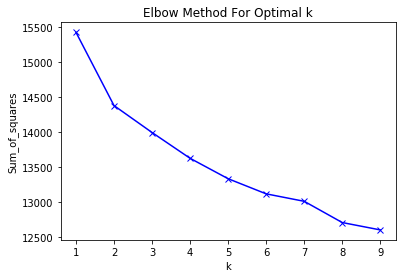

In [42]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(data_transformed)

In [44]:
labels = list(kmeans.labels_)
train['labels']=labels
train

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,CustomerID,Quantity,UnitPrice,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,...,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214,labels
0,0,12346,74215,1.04,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,12347,2458,481.21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,12348,2332,18.71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,12349,630,305.10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,12350,196,25.30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,2162,15290,4501,663.14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2163,2163,15291,2102,479.63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2164,2164,15292,56,115.82,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2165,2165,15296,1766,674.66,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [21]:
train1 = data.head(50000)
mms1 = MinMaxScaler()
mms1.fit(train1)
data_transformed1 = mms1.transform(train1)
kmeans1 = KMeans(n_clusters=5, random_state=0).fit(data_transformed1)

In [22]:
labels1 = list(kmeans1.labels_)
train1['labels']=labels1
train1

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,...,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214,labels
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,85123,6,2.55,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2010-12-01 08:26:00,71053,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2010-12-01 08:26:00,84406,8,2.75,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2010-12-01 08:26:00,84029,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2010-12-01 08:26:00,84029,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-02-03 13:58:00,22328,6,2.95,12662,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-02-03 13:58:00,22976,12,1.25,12662,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-02-03 13:58:00,22711,25,0.42,12662,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [46]:
count = pd.DataFrame(train.groupby(['labels','CustomerID']).sum().reset_index())
count

,labels,CustomerID,index,Quantity,UnitPrice,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
0,0,12415,55,77373,1747.08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12433,71,11071,920.95,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,12451,86,6574,827.33,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,12471,100,8104,1144.17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,12472,101,4120,686.81,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,4,15290,2162,4501,663.14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163,4,15291,2163,2102,479.63,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2164,4,15292,2164,56,115.82,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2165,4,15296,2165,1766,674.66,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
count1 = pd.DataFrame(train1.groupby(['labels','StockCode']).sum().reset_index())
count1

,labels,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
0,0,10002,87,7.65,155010,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,10120,3,0.42,35165,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,0,10123,1,0.65,17967,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,10124,9,0.84,33626,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,10125,143,3.81,104883,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,4,90200,47,72.25,296791,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5726,4,90204,2,6.70,35227,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
5727,4,90209,6,2.10,16607,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5728,4,90210,5,8.85,49740,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [53]:
group_1 = count1.loc[count1['labels'] == 0].sort_values(by='Quantity',ascending=False).head(10)
group_1

,labels,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
38,0,17003,3348,2.32,202616,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,0,22492,2736,10.85,297367,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1104,0,22469,2469,136.51,1442162,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1240,0,22616,2336,8.08,486072,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
690,0,21915,2253,38.18,532628,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
875,0,22189,2150,117.53,544624,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883,0,22197,2142,44.73,938815,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1105,0,22470,2087,230.22,1358337,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,0,22188,2070,34.02,176298,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,0,20668,1368,1.88,283082,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
group_2 = count1.loc[count1['labels'] == 1].sort_values(by='Quantity',ascending=False).head(10)
group_2

,labels,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
3140,1,23166,74215,1.04,12346,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940,1,21212,2484,25.60,626825,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2571,1,22328,1730,91.05,399522,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1712,1,17096,1728,0.17,12875,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1709,1,17084,1715,1.63,107963,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3013,1,22834,1399,66.70,558625,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,1,21977,1356,13.08,323471,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3118,1,22961,1348,96.55,878985,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2705,1,22492,1332,10.95,220704,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1707,1,17021,1266,1.08,54257,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
group_3 = count1.loc[count1['labels'] == 2].sort_values(by='Quantity',ascending=False).head(10)
group_3

,labels,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
3538,2,85099,5444,412.35,3072145,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3547,2,85123,3490,502.15,2500075,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3452,2,84879,2723,164.18,1375945,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3495,2,84997,2688,617.46,2350133,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3324,2,84077,2307,8.17,413392,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3493,2,84992,2292,39.35,1014794,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3492,2,84991,2045,31.65,824861,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3477,2,84950,1872,2.50,58247,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3227,2,70006,1809,31.46,411479,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3338,2,84347,1452,50.20,295473,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
group_4 = count1.loc[count1['labels'] == 3].sort_values(by='Quantity',ascending=False).head(10)
group_4

,labels,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
3940,3,21212,3471,32.67,939671,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3,21108,3267,32.25,199126,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4952,3,22693,2592,7.00,91602,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3917,3,21175,2269,90.05,655051,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3900,3,21137,2157,60.15,261159,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5080,3,22834,1816,113.80,1035468,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4219,3,21731,1556,30.15,290813,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4706,3,22423,1435,1374.00,1693171,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5304,3,47556,1300,2.55,15749,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4749,3,22469,1246,169.60,1571462,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
group_5 = count1.loc[count1['labels'] == 4].sort_values(by='Quantity',ascending=False).head(10)
group_5

,labels,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,...,StockCode_90202,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214
5423,4,84077,7056,5.61,342583,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5617,4,85123,6045,621.24,3703034,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5610,4,85099,3796,259.50,2303037,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5391,4,79321,2045,263.84,979232,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5529,4,84879,1811,137.62,1400395,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5398,4,82484,1274,248.64,705667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,4,84997,1000,429.81,1980389,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5377,4,79000,975,15.35,326772,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5416,4,84029,954,527.55,2497959,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5356,4,72351,922,102.95,848999,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
prediction = KMeans(n_clusters=5, random_state=0).fit_predict(test_transformed)
test['labels']=prediction
test

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,CustomerID,Quantity,UnitPrice,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,...,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214,labels
2167,2167,15298,3116,459.25,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2168,2168,15299,2947,19.61,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2169,2169,15300,292,80.14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2170,2170,15301,2775,730.12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2171,2171,15303,248,119.06,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4329,4329,18280,45,47.65,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4330,4330,18281,54,39.36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4331,4331,18282,103,62.39,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4332,4332,18283,1395,1214.98,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [80]:
def rec(data4):
    for i in data4:
        label = test.loc[test['CustomerID'] == i, 'labels']
        if label == 0:
            print(i + ': ' + group_1['StockCode'])
        elif label == 1:
            print(i + ': ' + group_2['StockCode'])

In [81]:
rec(test['CustomerID'])

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [24]:
def cluster_predict(input_code):
    prediction = kmeans.predict(input_code)
    return prediction

In [25]:
data['ClusterPrediction'] = ""

In [28]:
cluster_predict(data)

MemoryError: 

We first need to see how many customers bought items. To give an accurate recommendation, we want to make sure the data we are observing is based on frequent shoppers, and not periodic or one-time shoppers. To do so, we need to first observe the data by the actual **CustomerID** where we then want to see how many items each customer purchased.

In [6]:
km = dask_ml.cluster.KMeans(n_clusters=10, oversampling_factor=5, random_state=3)
km.fit(train)

KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=None,
       max_iter=300, n_clusters=10, n_jobs=1, oversampling_factor=5,
       precompute_distances='auto', random_state=None, tol=0.0001)

In [22]:
labels = list(km.labels_.compute())

data['labels']=labels
train

TypeError: compute() takes 1 positional argument but 2 were given

In [21]:
len(decks_labels)

6391

In [5]:
mms = MinMaxScaler()
mms.fit(train)
data_transformed = mms.transform(train)

In [6]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

In [16]:
Sum_of_squared_distances

[]

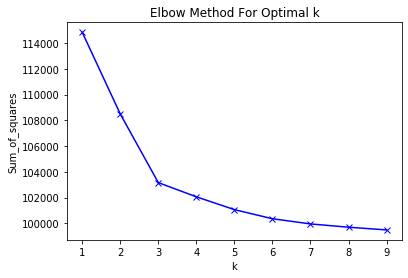

In [7]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
km = dask_ml.cluster.KMeans(n_clusters=3,oversampling_factor=5)
km.fit(data_transformed)

KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=None,
       max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=5,
       precompute_distances='auto', random_state=None, tol=0.0001)

In [44]:
labels = list(km.labels_.compute())
customer_labels = list(zip(data_transformed,labels))

In [64]:
train['labels']=labels
train

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,StockCode,Quantity,UnitPrice,CustomerID,StockCode_2,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123,StockCode_10124,...,StockCode_90204,StockCode_90205,StockCode_90206,StockCode_90208,StockCode_90209,StockCode_90210,StockCode_90211,StockCode_90212,StockCode_90214,labels
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,85123,6,2.55,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2010-12-01 08:26:00,71053,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2010-12-01 08:26:00,84406,8,2.75,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2010-12-01 08:26:00,84029,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2010-12-01 08:26:00,84029,6,3.39,17850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-04-07 13:45:00,22380,5,2.10,14981,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-04-07 13:45:00,22899,6,2.10,14981,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-04-07 13:45:00,22662,10,1.65,14981,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
train.sum(axis = 0, skipna = True) 

StockCode          3.286922e+09
Quantity           1.344191e+06
UnitPrice          3.063691e+05
CustomerID         1.530898e+09
StockCode_2        3.300000e+01
                       ...     
StockCode_90210    1.200000e+01
StockCode_90211    1.000000e+00
StockCode_90212    2.000000e+00
StockCode_90214    2.300000e+01
labels             7.518800e+04
Length: 3199, dtype: float64

In [50]:
group1 = train.loc[train['labels'] == 0].transpose()

In [55]:
group1.loc['StockCode_2':'StockCode_90214'].sum().sort_values(ascending=False)

InvoiceDate
2011-04-07 13:37:00    1.0
2011-01-09 12:02:00    1.0
2011-01-09 12:53:00    1.0
2011-01-09 12:53:00    1.0
2011-01-09 12:53:00    1.0
                      ... 
2011-02-25 10:29:00    1.0
2011-02-25 10:29:00    1.0
2011-02-25 10:29:00    1.0
2011-02-25 10:29:00    1.0
2010-12-01 08:26:00    1.0
Length: 41102, dtype: float64

In [61]:
group2 = train.loc[train['labels'] == 1].transpose()
group2.loc['StockCode_2':'StockCode_90214'].sum().sort_values(ascending=False)

InvoiceDate
2011-04-07 13:45:00    1.0
2011-01-17 13:25:00    1.0
2011-01-17 13:25:00    1.0
2011-01-17 13:25:00    1.0
2011-01-17 13:25:00    1.0
                      ... 
2011-03-02 11:48:00    1.0
2011-03-02 11:48:00    1.0
2011-03-02 11:48:00    1.0
2011-03-02 11:48:00    1.0
2010-12-01 08:34:00    1.0
Length: 42608, dtype: float64

In [62]:
group3 = train.loc[train['labels'] == 1].transpose()
group3.loc['StockCode_2':'StockCode_90214'].sum().sort_values(ascending=False)

InvoiceDate
2011-04-07 13:45:00    1.0
2011-01-17 13:25:00    1.0
2011-01-17 13:25:00    1.0
2011-01-17 13:25:00    1.0
2011-01-17 13:25:00    1.0
                      ... 
2011-03-02 11:48:00    1.0
2011-03-02 11:48:00    1.0
2011-03-02 11:48:00    1.0
2011-03-02 11:48:00    1.0
2010-12-01 08:34:00    1.0
Length: 42608, dtype: float64

We now want to remove the customers that did not purchase more than 50 times at the store. We only want customers who have purchased at least 50 times, therefore, we look at the **InvoiceNo** column and manipulate, accordingly. 

In [ ]:
# Customers less than 50 orders
df_clean=CustomerID.loc[lambda CustomerID: CustomerID['InvoiceNo'] > 50]
print(df_clean)
df_clean.reset_index().StockCode.hist(bins=50)

In [ ]:
cluster1=df[['StockCode','CustomerID']]
X_train, X_test, y_train, y_test = train_test_split(cluster1['StockCode'], cluster1['CustomerID'], test_size=0.33, random_state=42)
plt.scatter(X_test,y_test)
plt.show()

Create a DataFrame that indexed by the **StockCode** and use the **CustomerID** as the columns where we figured the values to be the **Quantity** shared between them. Normalize the data.

In [ ]:
# New DataFrame created to view the relationship between the custumer and the items purchased filling NaN with 0.
cluster1 = df_clean.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', aggfunc = np.sum).fillna(value=0)
# Normalizing the data.
cluster1_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster1_minmax)

Figured out the *optimal* **k** (number of clusters) for the DataFrame using the **Elbow Method** by obtaining initializing a range of values for **k**. We then plot this data to observe the plot for the **Elbow Point** which gives the optimal **k**. 

In [ ]:
# Gave a range for K to obtain the list of K values
Sum_of_squared = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared.append(km.inertia_)

In [ ]:
# Create the plot that will produce the elbow plot to give optimal value of k.
plt.plot(K, Sum_of_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

Create a DataFrame that indexed by the **CustomerID** and use the **StockCode** as the columns where we figured the values to be the **Quantity** shared between them. Normalize the data.

In [ ]:
# New DataFrame created to view the relationship between the custumer and the items purchased filling NaN with 0.
cluster2 = df_clean.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc = np.sum).fillna(value=0)
# Normalized the data.
cluster2_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster2_minmax)

In [ ]:
km = dask_ml.cluster.KMeans(n_clusters=3,oversampling_factor=5)
km.fit(cluster1)

In [ ]:
labels = list(km.labels_.compute())
customer_labels = list(zip(cluster1,labels))

In [ ]:
print(customer_labels)

In [ ]:
df['label'] = labels

In [ ]:
def most_common_items(cluster1, k):
    cluster1.sort(key = lambda labels: labels[0], reverse=True)
    return [customer_label[1] for customer_label in labels[:k]]  

def customers_by_label(a_label):
    return [(cluster1, label) for (cluster1, label) in customer_labels if label == a_label]

In [ ]:
label_counts = [(label,len(decks_by_label(label))) for label in range(3)]
counts = [count for _, count in label_counts]
points = {
    'cluster':[label for label, _ in label_counts],
    'count':[count for _, count in label_counts],
}

sns.barplot(x="cluster", y="count", data=points).set_title("Customers by Cluster")
plt.savefig('figure 1')

In [ ]:
# data-structure to store Sum-Of-Square-Errors
sse = {}
# Looping over multiple values of k from 1 to 30
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100).fit(cluster1)
    sse[k] = kmeans.inertia_
# Plotting the curve with 'k'-value vs SSE
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

In [ ]:
rec1 = pd.DataFrame(df.groupby('StockCode').count().sort_values(by='CustomerID',ascending=False))
rec1

In [ ]:
rec1 = rec1.sample(frac = 1) 
df_train = rec1.head().reset_index().sort_values('InvoiceNo',ascending=False)
df_test = rec1.tail().reset_index().sort_values('InvoiceNo', ascending = False)
print(df_train[df_train['StockCode'].isin(['85123','22423','20725'])])
print(df_test)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(cluster2)
labels = kmeans.predict(cluster2) ## this is the cluster number rows==(custid,clusternum)
print(labels)
print(pd.DataFrame(labels).mean())
df = np.transpose(pd.DataFrame([cluster2.reset_index().CustomerID,labels]))
### df_clean=CustomerID.loc[lambda CustomerID: CustomerID['InvoiceNo'] > 50]
print(df)

## 2.1 Recommendation (Clustering)

Figured out the *optimal* **k** (number of clusters) for the DataFrame using the **Elbow Method** by obtaining initializing a range of values for **k**. We then plot this data to observe the plot for the **Elbow Point** which gives the optimal **k**. 

In [ ]:
# Gave a range for K to obtain the set of K values
Sum_of_squared2 = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster2_minmax)
    Sum_of_squared2.append(km.inertia_)
print(Sum_of_squared2)

In [ ]:
# Create the plot that will produce the elbow plot to give optimal value of k.
plt.plot(K, Sum_of_squared2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

From observations above, it seems the the optimal K=10. We now can use this to give the number of recommended products of most purchased. 

In [ ]:
similar_to_contact = cluster2.corrwith(cluster1).dropna()
similar_to_contact

## 2.2 Recommendation (Most Purchased item)

We want to figure out how many of each product was purchased. Therefore, we need to group our original data by the **StockCode** to see how many customers purchased the item. This will allow us to see which item was purchased the most of all items. Once we have this data, we now recommend this item to all customers. 

In [ ]:
rec1 = pd.DataFrame(df_pos_price.groupby('StockCode').count().sort_values(by='CustomerID',ascending=False))
most_purchased = rec1['CustomerID'].head()
print(most_purchased)

## 2.3 Recommendation (New Items purchased)

Extract the products that only **one** customer purchased. These products that are considered **new** since it has no purchase history. Recommend this product to all customers.

In [ ]:
new_prod = rec1.loc[lambda rec1: rec1['CustomerID'] <= 10].sort_values(by = 'CustomerID', ascending = False)
new_product = new_prod['CustomerID']
print(new_product)

In [ ]:
rec1 = rec1.sample(frac = 1) 
df_train = rec1.head(2734).reset_index().sort_values('InvoiceNo',ascending=False)
df_test = rec1.tail(304).reset_index().sort_values('InvoiceNo', ascending = False)
print(df_train[df_train['StockCode'].isin(['85123','22423','20725'])])
print(df_test)

In [ ]:
print(df_test.sum())

In [ ]:
P = df_train.loc[lambda df_train: df_train['CustomerID'] >= 750]
most_purchased = pd.DataFrame(P, columns = ['CustomerID'])
print(most_purchased)